In [ ]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 45.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/TFG/Pruebas ejecucion

Mounted at /content/drive
/content/drive/MyDrive/TFG/Pruebas ejecucion


In [ ]:
from model import Transformer, CustomSchedule, masked_loss, masked_acc
from data_preprocessing import create_datasets, text_vectorization, process_text, MAX_VOCAB_SIZE, standardize_text

import tensorflow as tf
import tensorflow_text as tf_text
import numpy as np
import random
import matplotlib.pyplot as plt

import nltk
import nltk.translate.bleu_score as bleu
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import single_meteor_score
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\javiv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\javiv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
MODEL_NAME = 'weights/es_en__20_6_256_512_8_0-3.h5'

## Load model

In [ ]:
# Load the vocabulary
with open('vocab/es_en_context_vocabulary.txt', 'r', encoding='utf-8') as f:
    context_loaded_vocab = [line.strip() for line in f]

# Load the vocabulary
with open('vocab/es_en_target_vocabulary.txt', 'r', encoding='utf-8') as f:
    target_loaded_vocab = [line.strip() for line in f]

# Then create a new TextVectorization layer using the loaded vocabulary
context_text_processor = tf.keras.layers.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    standardize=standardize_text,
    vocabulary=context_loaded_vocab,
    ragged=True,
)

target_text_processor = tf.keras.layers.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    standardize=standardize_text,
    vocabulary=target_loaded_vocab,
    ragged=True,
)

In [ ]:
#! Model
num_layers = 6
d_model = 256
dff = 512
num_heads = 8
dropout_rate = 0.3

learning_rate = CustomSchedule(d_model)
my_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model = Transformer(
    num_layers = num_layers,
    d_model = d_model,
    num_heads = num_heads,
    dff = dff,
    input_vocab_size = context_text_processor.vocabulary_size(),
    target_vocab_size = target_text_processor.vocabulary_size(),
    dropout_rate = dropout_rate,
)

model.compile(
    loss = masked_loss,
    optimizer=my_optimizer,
    metrics = [masked_acc],
)

# Llama al modelo con datos ficticios para construirlo
dummy_input = tf.ones((1, 1), dtype=tf.int32)
dummy_context = tf.ones((1, 1), dtype=tf.int32)
model((dummy_context, dummy_input), training=False)

model.load_weights(MODEL_NAME)

## Inference

In [ ]:
def print_translation(sentence, translated_sentence, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {translated_sentence}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
def detokenize_sentence(processor, sentence):
  output_sentence = tf.constant('')
  vocab = processor.get_vocabulary()
  lookup = tf.constant('')

  for token in sentence:
    output_sentence = tf.strings.join([output_sentence, vocab[token]], separator=' ')

  lookup = tf.strings.split(output_sentence, sep=' ')

  sentence = output_sentence.numpy().decode('utf-8')
  sentence = sentence.replace('[START]', '').replace('[END]', '').strip()

  return sentence, lookup

In [ ]:
def translate(sentence, context_processor, target_processor, model, max_tokens=128):
  # Convert the sentence to tensor
  sentence = tf.constant([[sentence]])
  assert isinstance(sentence, tf.Tensor)

  # Give the correct shape
  if len(sentence.shape) == 0:
    sentence = sentence[tf.newaxis]
  
  # Tokenize the sentence
  sentence = context_processor(sentence).to_tensor()

  # Input for the encoder
  encoder_input = sentence
  
  # Input for the decoder
  start_end_tokens = target_processor([''])[0]
  start_token = start_end_tokens[0][tf.newaxis]
  end_token = start_end_tokens[-1][tf.newaxis]

  # Convert decoder sentence to TensorArray for feed the model
  output_tensor = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
  output_tensor = output_tensor.write(0, start_token)
  
  # seq_to_seq generation
  for i in tf.range(max_tokens):

    # Prepare the output tensor
    output = tf.transpose(output_tensor.stack())
    
    # Get the model predictions
    predictions = model((encoder_input, output), training=False)
    
    # Select the last token from the seq_len dimension
    predictions = predictions[:, -1, :] # Shape (batch_size, 1, vocab_size)
    # Get the most probable next token
    predicted_id = tf.argmax(predictions, axis=-1)

    # Concatenate the predicted token to the output sentence
    output_tensor = output_tensor.write(i+1, predicted_id) #TODO: en el tuto es predicted_id[0]

    # Check if the prediction is fully generated with the last token
    if predicted_id == end_token:
      break
  
  # Convert the output to the correct shape
  output = tf.transpose(output_tensor.stack()) # Shape (1, tokens_generated)

  # Detokenize the output sentence
  text, lookup = detokenize_sentence(target_processor, output[0])

  # 'tf.function' prevents us from using the attention_weights that were calculated on the
  # last iteration of the loop. So, recalculate them outside the loop.
  model((encoder_input, output[:, :-1]), training=False)
  attention_weigths = model.decoder.last_attn_scores
  #TODO: Check is attn_weigths is correct (with plotting function)

  return text, lookup, attention_weigths

In [ ]:
def batch_translate_single_batch(sentences, context_processor, target_processor, model, max_tokens=128):
    # Convert the sentences to a tensor
    sentences = tf.constant(sentences)
    assert isinstance(sentences, tf.Tensor)

    # Tokenize the sentences
    sentences = context_processor(sentences).to_tensor()

    # Input for the encoder
    encoder_input = sentences

    # Input for the decoder
    start_end_tokens = target_processor([''])[0]
    start_token = start_end_tokens[0][tf.newaxis]
    end_token = start_end_tokens[-1][tf.newaxis]
    end_token_id = end_token.numpy()[0]
    dot_token_id = target_processor.get_vocabulary().index('.')

    # Prepare the initial output tensor
    batch_size = tf.shape(encoder_input)[0]
    initial_output = tf.repeat(start_token, repeats=batch_size, axis=0)

    # Initialize the output tensor as a list of empty TensorArrays, one for each sentence
    output_tensors = [tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True) for _ in range(batch_size)]

    # Write the start token to each TensorArray
    for i, tensor_array in enumerate(output_tensors):
        tensor_array = tensor_array.write(0, initial_output[i])
        tensor_array.mark_used()
   

    # Initialize a boolean tensor to track the completed sentences
    completed_sentences = tf.zeros(batch_size, dtype=tf.bool)

    for _ in tf.range(max_tokens):
        # Prepare the output tensor
        max_sentence_length = max([tensor_array.size() for tensor_array in output_tensors])
        padded_output_tensors = [tf.pad(tensor_array.stack(), [[0, max_sentence_length - tensor_array.size()]]) for tensor_array in output_tensors]
        output = tf.stack(padded_output_tensors, axis=0)

        # Get the model predictions
        predictions = model((encoder_input, output), training=False)

        # Select the last token from the seq_len dimension
        predictions = predictions[:, -1, :]  # Shape (batch_size, 1, vocab_size)

        # Get the most probable next token
        predicted_ids = tf.argmax(predictions, axis=-1)

        # Concatenate the predicted token to the output sentence
        for i, (tensor_array, predicted_id) in enumerate(zip(output_tensors, predicted_ids)):
            if not completed_sentences[i]:
                if predicted_id.numpy() == end_token_id or predicted_id == dot_token_id:
                    completed_sentences = tf.where(tf.range(batch_size) == i, True, completed_sentences)
                    output_tensors[i] = tensor_array.write(tensor_array.size(), predicted_id)
                else:
                    output_tensors[i] = tensor_array.write(tensor_array.size(), predicted_id)
            else:
                # Keep the end token if the sentence is already completed
                output_tensors[i] = tensor_array.write(tensor_array.size(), end_token_id)

        # Check if all the predictions are fully generated with the last token
        if tf.reduce_all(completed_sentences):
            break
    

    # Convert the output to the correct shape
    output = tf.stack([tensor_array.stack() for tensor_array in output_tensors], axis=0)  # Shape (batch_size, tokens_generated)

    # Detokenize the output sentences
    texts, lookups = [], []
    for i in range(batch_size):
        text, lookup = detokenize_sentence(target_processor, output[i])
        texts.append(text)
        lookups.append(lookup)

    # 'tf.function' prevents us from using the attention_weights that were calculated on the
    # last iteration of the loop. So, recalculate them outside the loop.
    model((encoder_input, output[:, :-1]), training=False)
    attention_weights = model.decoder.last_attn_scores

    return texts, lookups, attention_weights

In [ ]:
def batch_translate(sentences, context_processor, target_processor, model, max_tokens=128, batch_size=16):
    num_batches = len(sentences) // batch_size + int(len(sentences) % batch_size > 0)
    all_translated_texts = []
    # all_lookups = []
    # all_attention_weights = []

    for i in range(num_batches):
        print('Batch starting... ' + str(i+1) + '/' + str(num_batches))
        batch_start = i * batch_size
        batch_end = min((i + 1) * batch_size, len(sentences))
        batch_sentences = sentences[batch_start:batch_end]
        
        # Call the previous batch_translate function with the smaller batch of sentences
        translated_text, lookup, attention_weights = batch_translate_single_batch(batch_sentences, context_processor, target_processor, model, max_tokens)
        
        all_translated_texts.extend(translated_text)
        # all_lookups.extend(lookup)
        # all_attention_weights.append(attention_weights)

    return all_translated_texts, _, __
    # return all_translated_texts, all_lookups, all_attention_weights

In [ ]:
sentence = 'Quiero estar en casa hoy'
ground_truth = 'I want to be at home today'

translated_text, lookup, attention_weigths = translate(sentence, context_text_processor, target_text_processor, model)
print_translation(sentence, translated_text, ground_truth)

Input:         : Quiero estar en casa hoy
Prediction     : i want to be at home today
Ground truth   : I want to be at home today


In [ ]:
sentence = 'Me gusta beber agua en el parque'
ground_truth = 'I like to drink water in the park'

translated_text, lookup, attention_weigths = translate(sentence, context_text_processor, target_text_processor, model)
print_translation(sentence, translated_text, ground_truth)

Input:         : Me gusta beber agua en el parque
Prediction     : i like to drink water at the park
Ground truth   : I like to drink water in the park


In [ ]:
sentence = 'La universidad me ha enseñado que la vida no consiste sólo en tener conocimientos técnicos, sino también en conocer a gente que puede ayudarte en el futuro.'
ground_truth = 'university has taught me that life is not only about technical knowledge, but also about meeting people who can help you in the future.'

translated_text, lookup, attention_weigths = translate(sentence, context_text_processor, target_text_processor, model)
print_translation(sentence, translated_text, ground_truth)

Input:         : La universidad me ha enseñado que la vida no consiste sólo en tener conocimientos técnicos, sino también en conocer a gente que puede ayudarte en el futuro.
Prediction     : the university has taught me that life is not only in having technical knowledge , but also know people who can help in future .
Ground truth   : university has taught me that life is not only about technical knowledge, but also about meeting people who can help you in the future.


### Beam search

In [ ]:
def expand_beams(beam, model, encoder_input, beam_width):
    tokens, score = beam

    # Convert tokens to tensor
    output = tf.convert_to_tensor([tokens])

    # Get the model predictions
    predictions = model((encoder_input, output), training=False)
    
    # Select the last token from the seq_len dimension
    predictions = predictions[0, -1, :]  # Shape (vocab_size,)

    # Get the beam_width most probable next tokens
    predicted_ids = tf.math.top_k(predictions, k=beam_width).indices.numpy()
    
    # Calculate log probabilities of the most probable tokens
    log_probs = tf.math.log(tf.nn.softmax(predictions))
    # Get the log probabilities of the predicted_ids
    predicted_log_probs = tf.gather(log_probs, predicted_ids)


    new_beams = []
    for predicted_id, predicted_log_prob in zip(predicted_ids, predicted_log_probs):
        # Manually penalize if the predicted token is [UNK] to avoid its use as much as possible.
        if predicted_id == 1:
          predicted_log_prob-=2.5

        new_beam = (list(tokens) + [predicted_id], score + predicted_log_prob.numpy())
        new_beams.append(new_beam)

    return new_beams

In [ ]:
def translate_beam(sentence, context_processor, target_processor, model, max_tokens=64, beam_width = 5):
  # Convert the sentence to tensor
  sentence = tf.constant([[sentence]])
  assert isinstance(sentence, tf.Tensor)

  # Give the correct shape
  if len(sentence.shape) == 0:
    sentence = sentence[tf.newaxis]
  
  # Tokenize the sentence
  sentence = context_processor(sentence).to_tensor()

  # Input for the encoder
  encoder_input = sentence
  
  # Input for the decoder
  start_end_tokens = target_processor([''])[0]
  start_token = start_end_tokens[0][tf.newaxis]
  end_token = start_end_tokens[-1][tf.newaxis]
  dot_token = tf.convert_to_tensor([target_processor.get_vocabulary().index('.')], dtype=tf.int64)

  # Convert decoder sentence to TensorArray for feed the model
  output_tensor = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
  output_tensor = output_tensor.write(0, start_token)
  output_tensor.mark_used()

  # Define params for beam search
  active_beams = [(start_token.numpy(), 0.0)]  # Each beam is a pair of (tokens, score)
  final_beams = []

  for i in tf.range(max_tokens):
      next_beams = []
      for beam in active_beams:
          # print(beam)
          # Expand the current beam by all possible next tokens
          expanded_beams = expand_beams(beam, model, encoder_input, beam_width)

          # Add the expanded beams to next_beams
          next_beams.extend(expanded_beams)
          


      # Prune down to the beam_width highest scoring beams
      next_beams.sort(key=lambda x: x[1], reverse=True)
      active_beams = next_beams[:beam_width]

      
      # Check if any of the active beams have produced an end token
      # completed_beams = [(beam for beam in active_beams if beam[0][-1] == end_token) or (beam for beam in active_beams if beam[0][-1] == dot_token)]
      completed_beams = [beam for beam in active_beams if beam[0][-1] == end_token]
      active_beams = [beam for beam in active_beams if beam not in completed_beams]
      
      # Add the completed beams to a final hypotheses list
      final_beams.extend(completed_beams)
      
      # If there are enough final hypotheses, break
      if len(final_beams) >= beam_width:
          break
  
  # Sort the final output by the log error
  final_beams.sort(key=lambda x: x[1], reverse=True)
  # Get the best translation
  if len(final_beams) == 0:
    output = active_beams[0][0]
  else:
    output = final_beams[0][0]
  output = tf.convert_to_tensor([output], dtype=tf.int64)

  # Detokenize the output sentence
  text, lookup = detokenize_sentence(target_processor, output[0])

  # 'tf.function' prevents us from using the attention_weights that were calculated on the
  # last iteration of the loop. So, recalculate them outside the loop.
  model((encoder_input, output[:, :-1]), training=False)
  attention_weigths = model.decoder.last_attn_scores
  #TODO: Check is attn_weigths is correct (with plotting function)

  return text, lookup, attention_weigths

In [ ]:
sentence = 'Quiero estar en casa hoy'
ground_truth = 'I want to be at home today'

translated_text, lookup, attention_weigths = translate_beam(sentence, context_text_processor, target_text_processor, model)
print_translation(sentence, translated_text, ground_truth)

Input:         : Quiero estar en casa hoy
Prediction     : i want to be at home today
Ground truth   : I want to be at home today


In [ ]:
sentence = 'Me gusta beber agua en el parque'
ground_truth = 'I like to drink water in the park'

translated_text, lookup, attention_weigths = translate_beam(sentence, context_text_processor, target_text_processor, model)
print_translation(sentence, translated_text, ground_truth)

Input:         : Me gusta beber agua en el parque
Prediction     : i like to drink water at the park
Ground truth   : I like to drink water in the park


In [ ]:
sentence = 'La universidad me ha enseñado que la vida no consiste sólo en tener conocimientos técnicos, sino también en conocer a gente que puede ayudarte en el futuro.'
ground_truth = 'university has taught me that life is not only about technical knowledge, but also about meeting people who can help you in the future.'

translated_text, lookup, attention_weigths = translate_beam(sentence, context_text_processor, target_text_processor, model)
print_translation(sentence, translated_text, ground_truth)

Input:         : La universidad me ha enseñado que la vida no consiste sólo en tener conocimientos técnicos, sino también en conocer a gente que puede ayudarte en el futuro.
Prediction     : the university has taught me that life is not only in having technical knowledge , but also know people who can help in future .
Ground truth   : university has taught me that life is not only about technical knowledge, but also about meeting people who can help you in the future.


# Evaluation

In [ ]:
#open file E:\TFG\eval
with open('eval/europarl-v7.es-en.es', 'r') as f:
    data_ori = f.readlines()

In [ ]:
with open('eval/europarl-v7.es-en.en', 'r') as f:
    data_dst = f.readlines()

In [ ]:
num_sentences = 128
sentences_ori = []
sentences_dest = []

def get_sentence_pairs(num_sentences):
  # get num_sentences random sentences from the data
  for i in range(num_sentences):
    index = random.randint(0, len(data_ori))
    sentences_ori.append(data_ori[index])
    sentences_dest.append(data_dst[index])

In [ ]:
get_sentence_pairs(num_sentences)

print(len(sentences_ori))
print(len(sentences_dest))

print(sentences_ori[0])
print(sentences_dest[0])

print(sentences_ori[-1])
print(sentences_dest[-1])

128
128
También le pregunto: ¿Cuándo calcula que estén sobre el terreno?

I might also ask: when do you anticipate that they will be in place?

También nos ha demostrado que, en algunos casos, es necesario.

You also demonstrated to us that, in certain cases, it was necessary.



In [ ]:
translated_sentences, _, __ = batch_translate(sentences_ori, context_text_processor, target_text_processor, model, batch_size=32)

Batch starting... 1/4
Batch starting... 2/4
Batch starting... 3/4
Batch starting... 4/4


In [ ]:
translations = []

In [ ]:
for sent in sentences_ori:
  y, _, __ = translate_beam(sent, context_text_processor, target_text_processor, model, beam_width=5)
  translations.append(y)

In [ ]:
len(translations)

128

In [ ]:
esp = [x.lower() for x in sentences_dest]

## BLEU score

In [ ]:
def calculate_bleu_score(references, predictions):
    # Tokenize the sentences
    tokenized_references = [word_tokenize(ref) for ref in references]
    tokenized_predictions = [word_tokenize(pred) for pred in predictions]

    # Calculate the BLEU score using the NLTK library
    bleu_score = bleu.corpus_bleu([[ref] for ref in tokenized_references], tokenized_predictions)
    return bleu_score

In [ ]:
bleu_score = calculate_bleu_score(sentences_dest, translated_sentences)
print("BLEU Score:", bleu_score)

NameError: name 'sentences_dest' is not defined

In [ ]:
bleu_score = calculate_bleu_score(esp, translated_sentences)
print("BLEU Score:", bleu_score)

BLEU Score: 0.2139294354333516


In [ ]:
bleu_score = calculate_bleu_score(esp, translations)
print("BLEU Score:", bleu_score)

BLEU Score: 0.23534285528281884


## Meteor score

In [ ]:
def calculate_meteor_score(references, predictions):
    # Tokenize the sentences
    tokenized_references = [word_tokenize(ref) for ref in references]
    tokenized_predictions = [word_tokenize(pred) for pred in predictions]

    # Calculate the METEOR score
    scores = [single_meteor_score(ref, pred) for ref, pred in zip(tokenized_references, tokenized_predictions)]
    average_score = sum(scores) / len(scores)

    return average_score

In [ ]:
meteor_score = calculate_meteor_score(sentences_dest, translated_sentences)
print("METEOR Score:", meteor_score)

METEOR Score: 0.48892485354087856


In [ ]:
meteor_score = calculate_meteor_score(esp, translated_sentences)
print("METEOR Score:", meteor_score)

METEOR Score: 0.48892485354087856


In [ ]:
meteor_score = calculate_meteor_score(esp, translations)
print("METEOR Score:", meteor_score)

METEOR Score: 0.515510140794458


# Attention Plots

In [ ]:
sentence = 'Quiero estar en casa hoy'
ground_truth = 'I want to be at home today'

translated_text, lookup, attention_weigths = translate_beam(sentence, context_text_processor, target_text_processor, model)
print_translation(sentence, translated_text, ground_truth)

Input:         : Quiero estar en casa hoy
Prediction     : i want to be at home today
Ground truth   : I want to be at home today


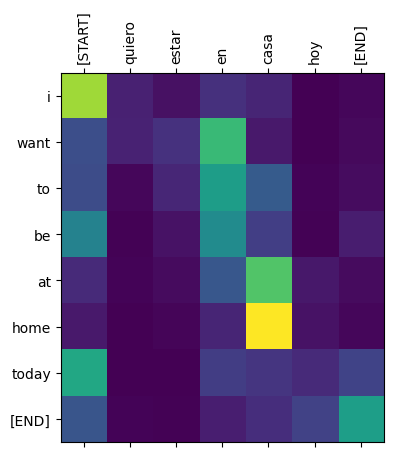

In [ ]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weigths, 0)
attention = attention_heads[head]

in_tokens = tf.convert_to_tensor([sentence])
in_tokens = context_text_processor(in_tokens).to_tensor()

def plot_attention_head(in_tokens, translated_sentence, attention, context_processor):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_sentence[2:]
  vocab_context = context_processor.get_vocabulary()

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens.numpy()[0])))
  ax.set_yticks(range(len(translated_tokens)))

  x_labels = [vocab_context[a] for token in in_tokens.numpy() for a in token]
  ax.set_xticklabels(
      x_labels, rotation=90)

  y_labels = [token.numpy().decode('utf-8') for token in translated_tokens]
  ax.set_yticklabels(y_labels)

plot_attention_head(in_tokens, lookup, attention, context_text_processor)

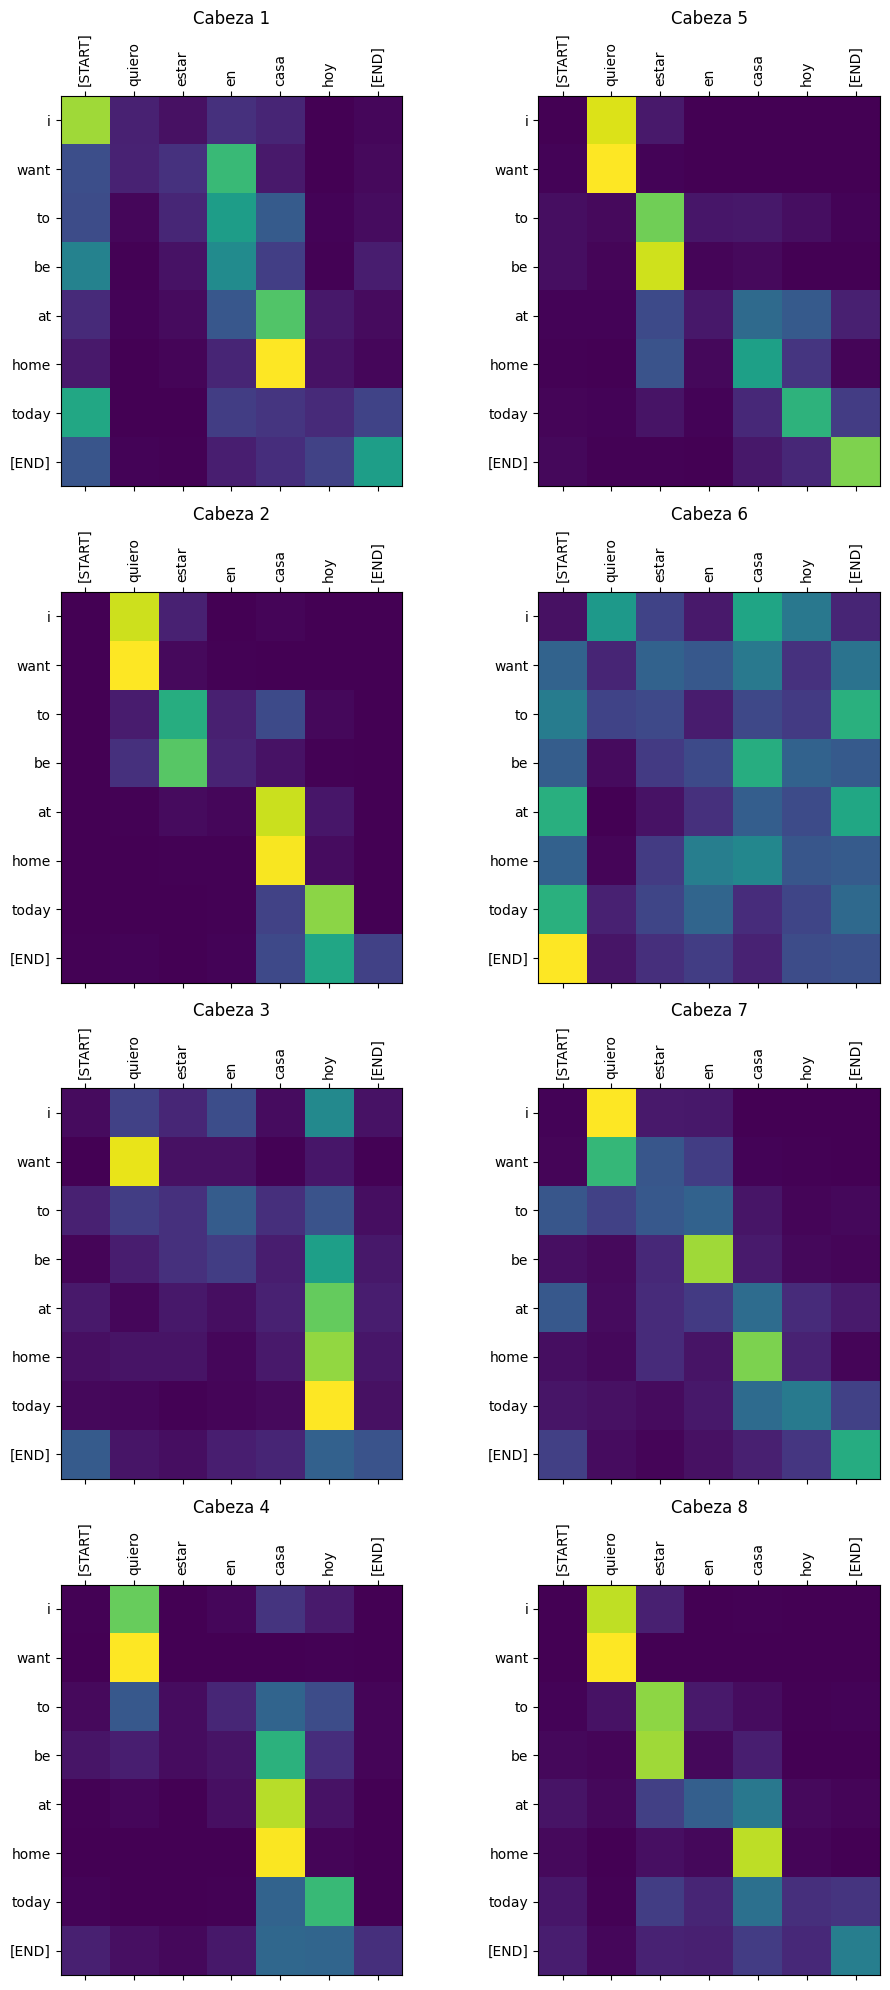

In [ ]:
def plot_attention_heads(in_tokens, translated_sentence, attention_heads, context_processor):
    # The model didn't generate `<START>` in the output. Skip it.
    translated_tokens = translated_sentence[2:]
    vocab_context = context_processor.get_vocabulary()

    num_heads = attention_heads.shape[0]
    fig, axs = plt.subplots(num_heads // 2, 2, figsize=(10, 20)) # adjust figsize as needed

    for head in range(num_heads):
        attention = attention_heads[head]
        row = head % (num_heads // 2)
        col = head // (num_heads // 2)

        axs[row, col].matshow(attention)
        axs[row, col].set_xticks(range(len(in_tokens.numpy()[0])))
        axs[row, col].set_yticks(range(len(translated_tokens)))

        x_labels = [vocab_context[a] for a in in_tokens.numpy()[0]]
        axs[row, col].set_xticklabels(x_labels, rotation=90)

        y_labels = [token.numpy().decode('utf-8') for token in translated_tokens]
        axs[row, col].set_yticklabels(y_labels)
        
        axs[row, col].set_title(f'Cabeza {head+1}')

    plt.tight_layout()
    plt.show()

plot_attention_heads(in_tokens, lookup, attention_heads, context_text_processor)